**IMPORTING REQUIRED LIBRARIES**

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

**The data is a text file (.txt) of English-German sentence pairs. We have to read the file first**

In [3]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

**Another function is defined to split the text into English-German pairs. Then we split these pairs into English sentences and German sentences respectively.** 

In [4]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

**We can use the below functions to read the text into an array in our desired format.**

In [5]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

**The actual data contains over 150,000 sentence-pairs. 
However, we will use only the first 50,000 sentence pairs to reduce the training time of the model.
This number can be changes as per system's computation power.**

In [6]:
deu_eng = deu_eng[:50000,:]

**Text Pre-Processing**
Quite an important step in any project, especially so in NLP. The data we work with is more often than not unstructured so there are certain things we need to take care of before jumping to the model building part.

**(a) Text Cleaning**

Let’s first take a look at our data. This will help us decide which pre-processing steps to adopt.

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

**Now get rid of the punctuation marks and then convert all the text to lower case.**

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn', 'Wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together', 'Wir waren zusammen auf Reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together', 'Wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [9]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['we took a wrong turn', 'wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['we traveled together', 'wir waren zusammen auf reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['we traveled together', 'wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

**(b) Text to Sequence Conversion**

A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.

But before we do that, let’s visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

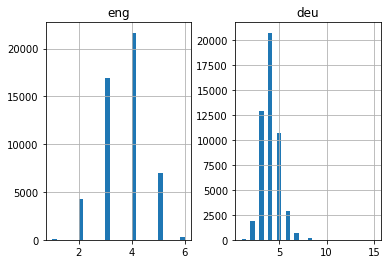

In [10]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

**Quite intuitive** – the maximum length of the German sentences is 11 and that of the English phrases is 8.

Next, vectorize our text data by using **Keras’s Tokenizer() class**. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

Note that **we will prepare tokenizers for both the German and English sentences:**

In [11]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [12]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6152


In [13]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10112


**The below code block contains a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.**

In [14]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

**Model Building**
We will now split the data into train and test set for model training and evaluation, respectively.

In [15]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It’s time to encode the sentences. We will encode **German sentences as the input sequences** and **English sentences as the target sequences**. This has to be done for both the train and test datasets.

In [16]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now we’ll start off by defining our Seq2Seq model architecture:

For the encoder, we will use an embedding layer and an LSTM layer
For the decoder, we will use another LSTM layer followed by a dense layer
Encoder Decoder model architecture


**Model Architecture**

In [17]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

**We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.**

In [18]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [19]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Please note that we have used **‘sparse_categorical_crossentropy‘** as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.

We are all set to start training our model!

We will train it for **30 epochs and with a batch size of 512 with a validation split of 20%**. 80% of the data will be used for training the model and the rest for evaluating it. You may change and play around with these hyperparameters.

We will also use the **ModelCheckpoint()** function to save the model with the lowest validation loss.

In [20]:
filename = 'model.h1.30_july_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 184s 3s/step - loss: 4.2993 - val_loss: 2.7590

Epoch 00001: val_loss improved from inf to 2.75903, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 2/30
63/63 [==============================] - 161s 3s/step - loss: 2.7220 - val_loss: 2.7022

Epoch 00002: val_loss improved from 2.75903 to 2.70216, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 3/30
63/63 [==============================] - 160s 3s/step - loss: 2.5671 - val_loss: 2.5826

Epoch 00003: val_loss improved from 2.70216 to 2.58257, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 4/30
63/63 [==============================] - 161s 3s/step - loss: 2.3804 - val_loss: 2.3823

Epoch 00004: val_loss improved from 2.58257 to 2.38229, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 5/30
63/63 [==============================] - 160s 3s/step - loss: 2.2286 - val_loss: 2.2489

Epoch 00005: val_loss improved from 2.38229 to 2.24890, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 6/30
63/63 [==============================] - 159s 3s/step - loss: 2.0912 - val_loss: 2.1281

Epoch 00006: val_loss improved from 2.24890 to 2.12805, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 7/30
63/63 [==============================] - 159s 3s/step - loss: 1.9432 - val_loss: 2.0397

Epoch 00007: val_loss improved from 2.12805 to 2.03967, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 8/30
63/63 [==============================] - 159s 3s/step - loss: 1.8263 - val_loss: 1.9648

Epoch 00008: val_loss improved from 2.03967 to 1.96483, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 9/30
63/63 [==============================] - 158s 3s/step - loss: 1.7133 - val_loss: 1.8835

Epoch 00009: val_loss improved from 1.96483 to 1.88353, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 10/30
63/63 [==============================] - 158s 3s/step - loss: 1.6083 - val_loss: 1.8054

Epoch 00010: val_loss improved from 1.88353 to 1.80543, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 11/30
63/63 [==============================] - 158s 3s/step - loss: 1.5101 - val_loss: 1.7564

Epoch 00011: val_loss improved from 1.80543 to 1.75641, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 12/30
63/63 [==============================] - 162s 3s/step - loss: 1.4186 - val_loss: 1.6947

Epoch 00012: val_loss improved from 1.75641 to 1.69469, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 13/30
63/63 [==============================] - 161s 3s/step - loss: 1.3162 - val_loss: 1.6454

Epoch 00013: val_loss improved from 1.69469 to 1.64542, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 14/30
63/63 [==============================] - 160s 3s/step - loss: 1.2438 - val_loss: 1.5980

Epoch 00014: val_loss improved from 1.64542 to 1.59800, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 15/30
63/63 [==============================] - 159s 3s/step - loss: 1.1693 - val_loss: 1.5559

Epoch 00015: val_loss improved from 1.59800 to 1.55593, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 16/30
63/63 [==============================] - 159s 3s/step - loss: 1.0836 - val_loss: 1.5029

Epoch 00016: val_loss improved from 1.55593 to 1.50288, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 17/30
63/63 [==============================] - 158s 3s/step - loss: 1.0131 - val_loss: 1.4874

Epoch 00017: val_loss improved from 1.50288 to 1.48740, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 18/30
63/63 [==============================] - 158s 3s/step - loss: 0.9444 - val_loss: 1.4372

Epoch 00018: val_loss improved from 1.48740 to 1.43721, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 19/30
63/63 [==============================] - 161s 3s/step - loss: 0.8788 - val_loss: 1.4151

Epoch 00019: val_loss improved from 1.43721 to 1.41506, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 20/30
63/63 [==============================] - 160s 3s/step - loss: 0.8108 - val_loss: 1.3816

Epoch 00020: val_loss improved from 1.41506 to 1.38161, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 21/30
63/63 [==============================] - 159s 3s/step - loss: 0.7553 - val_loss: 1.3493

Epoch 00021: val_loss improved from 1.38161 to 1.34934, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 22/30
63/63 [==============================] - 159s 3s/step - loss: 0.6995 - val_loss: 1.3352

Epoch 00022: val_loss improved from 1.34934 to 1.33516, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 23/30
63/63 [==============================] - 161s 3s/step - loss: 0.6422 - val_loss: 1.3164

Epoch 00023: val_loss improved from 1.33516 to 1.31640, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 24/30
63/63 [==============================] - 159s 3s/step - loss: 0.5992 - val_loss: 1.3018

Epoch 00024: val_loss improved from 1.31640 to 1.30175, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 25/30
63/63 [==============================] - 160s 3s/step - loss: 0.5453 - val_loss: 1.2860

Epoch 00025: val_loss improved from 1.30175 to 1.28597, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 26/30
63/63 [==============================] - 165s 3s/step - loss: 0.5060 - val_loss: 1.2837

Epoch 00026: val_loss improved from 1.28597 to 1.28372, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 27/30
63/63 [==============================] - 163s 3s/step - loss: 0.4626 - val_loss: 1.2681

Epoch 00027: val_loss improved from 1.28372 to 1.26815, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 28/30
63/63 [==============================] - 162s 3s/step - loss: 0.4263 - val_loss: 1.2685

Epoch 00028: val_loss did not improve from 1.26815
Epoch 29/30
63/63 [==============================] - 162s 3s/step - loss: 0.3830 - val_loss: 1.2555

Epoch 00029: val_loss improved from 1.26815 to 1.25552, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Epoch 30/30
63/63 [==============================] - 161s 3s/step - loss: 0.3531 - val_loss: 1.2526

Epoch 00030: val_loss improved from 1.25552 to 1.25259, saving model to model.h1.30_july_21


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


INFO:tensorflow:Assets written to: model.h1.30_july_21/assets


Let’s compare the training loss and the validation loss.

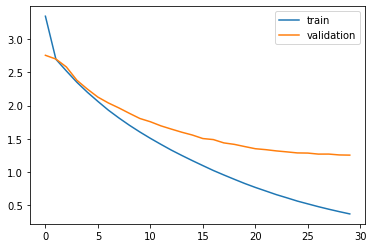

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 20 epochs.

Finally, we can load the saved model and make predictions on the unseen data – testX.

In [22]:
model = load_model('model.h1.30_july_21')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


These predictions are sequences of integers. We need to convert these integers to their corresponding words. Let’s define a function to do this:

In [23]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

Convert predictions into text (English):

In [24]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

Let’s put the original English sentences in the test dataset and the predicted sentences in a dataframe:

In [25]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

We can randomly print some actual vs predicted instances to see how our model performs:

In [26]:
pd.set_option('display.max_colwidth', 200)

In [27]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
15,it wont work,that doesnt work
5908,i want you to stop,i want you to stop
6442,its a beautiful day,its a nice day
4751,have a beer with me,have a drink beer
5926,tom was married,tom was married
3201,she gets up early,theyre up early
3741,tom didnt agree,tom wasnt notice
7429,roses are beautiful,cats are smart
4356,were on your side,were on your side
485,please step aside,please step aside


In [28]:
pred_df.head(15)

,actual,predicted
0,what is the number,whats the number
1,try it on,try it on
2,we were wrong,we were wrong
3,thats untrue,this not right
4,dont touch anything,dont touch
5,tom is calling back,tom will back
6,i think tom is awake,i think tom is
7,what are you having,what can it
8,i like that flag,i like this flag
9,you have a good job,you have a good


In [29]:
pred_df.tail(15)

,actual,predicted
9985,i saw you looking,i saw you before
9986,tom was so busy,tom was that night
9987,where could he be,where did he be
9988,my friend was shot,my hair was very
9989,come on trust me,come and help me
9990,life is too short,life is too
9991,everybody saw it,everyone saw it
9992,try harder,try harder next
9993,he will be punished,he is be urgent
9994,i speak swedish,i will dance
